In [1]:
import warnings
#warnings.filterwarnings('ignore')

In [13]:
import os
import pyspark
from pyspark.sql import SparkSession, functions as F
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
from lifelines import CoxPHFitter

os.environ["SPARK_HOME"] = pyspark.__path__[0]
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"
os.environ["PYSPARK_PYTHON"] = "python"

spark = (
    SparkSession.builder
    .config("spark.driver.memory", "8g")
    .getOrCreate()
)

In [2]:
levels = spark.read.csv("../data/20210801_all_levels.csv", header=True, inferSchema=True).cache()
ranking = spark.read.csv("../data/20210801_all_ranking.csv", header=True, inferSchema=True).cache()

levels.createOrReplaceTempView("levels")
ranking.createOrReplaceTempView("ranking")

levels.printSchema()
ranking.printSchema()

root
 |-- level: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- timestamp: string (nullable = true)

root
 |-- name: string (nullable = true)
 |-- level: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- specialization: string (nullable = true)
 |-- mastery: string (nullable = true)
 |-- fame: integer (nullable = true)
 |-- guild: string (nullable = true)
 |-- rank: integer (nullable = true)



In [55]:
def get_df(level):
    pivot_expr = ",".join(
        [
            f"min(if(level=={i}, diff_seconds, null)) as ttl_{i}"
            for i in range(3, level)
            if i >= level - 10
        ]
    )

    df = spark.sql(f"""
    with jobs as (
        select name, job
        from ranking
    ),
    ttl as (
        select
            name,
            job,
            level,
            first(timestamp) over (partition by name order by level) as first_ts,
            lag(timestamp) over (partition by name order by level) as last_ts,
            unix_timestamp(from_utc_timestamp(timestamp, "Z"))
                - unix_timestamp(from_utc_timestamp(lag(timestamp) over (partition by name order by level), "Z"))
                as diff_seconds,
            unix_timestamp(from_utc_timestamp(timestamp, "Z"))
                - unix_timestamp(from_utc_timestamp(first(timestamp) over (partition by name order by level), "Z"))
                as cum_diff_seconds
        from levels
        join jobs
        using (name)
    ),
    pivoted as (
        select
            name,
            job,
            min(if(level={level} and diff_seconds is not null, diff_seconds, 
                unix_timestamp(from_utc_timestamp("2021-08-01", "Z")) 
                - unix_timestamp(from_utc_timestamp(last_ts, "Z"))
            )) as duration,
            min(if(level={level} and cum_diff_seconds is not null, cum_diff_seconds, 
                unix_timestamp(from_utc_timestamp("2021-08-01", "Z")) 
                - unix_timestamp(from_utc_timestamp(first_ts, "Z"))
            )) as age,
            max(if(level={level}, 1, 0)) as observed,
            {pivot_expr}
        from ttl
        group by name, job
    )
    select * from pivoted
    where
        duration >=0
        and ttl_{level-2} is not null
    """)
    return df.toPandas()

df = get_df(170)

In [56]:
df

,name,job,duration,age,observed,ttl_160,ttl_161,ttl_162,ttl_163,ttl_164,ttl_165,ttl_166,ttl_167,ttl_168,ttl_169
0,BushyBrows,magician,169809,24495861,1,1095648.0,3818147.0,107583.0,78518.0,1031467.0,341804.0,1997359.0,2503322.0,196098,348167.0
1,Expert,bowman,2408556,29074699,1,946950.0,169198.0,408092.0,109963.0,238380.0,260661.0,5017183.0,4660028.0,1136879,4347632.0
2,Heaven,warrior,108992,8551106,1,346917.0,290695.0,252297.0,175883.0,238868.0,105188.0,173780.0,349173.0,349440,656570.0
3,Helmut,magician,159664,96907151,1,246408.0,221884.0,1316439.0,641386.0,378215.0,109342.0,190481.0,338139.0,190132,148532.0
4,Jeuras,thief,10634628,39490585,0,600979.0,376452.0,1123459.0,1485797.0,747341.0,1117224.0,803883.0,1526370.0,9432375,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,CauTionNL,thief,852269,29559702,1,5168647.0,4158860.0,588134.0,292125.0,317220.0,205652.0,345324.0,397451.0,371054,339455.0
2055,JayChou,magician,70911,7495276,1,160784.0,92197.0,83734.0,95808.0,425320.0,190247.0,163736.0,251500.0,95879,73188.0
2056,ReidoGado,magician,99486,30014003,1,265846.0,276323.0,429694.0,413369.0,191135.0,141454.0,171148.0,245194.0,88334,111898.0
2057,lxXxI,thief,266328,35015993,1,405319.0,205229.0,224046.0,260322.0,189511.0,441093.0,339132.0,273763.0,258120,342008.0


## basic cox

<AxesSubplot:xlabel='log(HR) (95% CI)'>

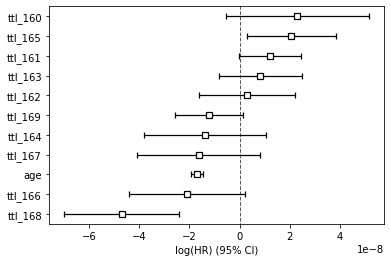

In [57]:
x = df.drop(columns=["name", "job"]).fillna(0).copy()
cph = CoxPHFitter()
cph.fit(x, duration_col="duration", event_col="observed")
cph.plot()

In [61]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 2059 total observations, 213 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 2059
number of events observed = 1846
   partial log-likelihood = -12387.67
         time fit was run = 2021-08-11 05:22:45 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age        -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_160     0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ttl_161     0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ttl_162     0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ttl_163     0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ttl_164    -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ttl_165     0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
ttl_166    -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ttl_167    -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ttl_168    -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_169    -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00

               z      p   -log2(p)
covariate                         
age       -14.27 <0.005     151.12
ttl_160     1.58   0.11       3.12
ttl_161     1.95   0.05       4.30
ttl_162     0.29   0.77       0.38
ttl_163     0.98   0.33       1.61
ttl_164    -1.11   0.27       1.91
ttl_165     2.29   0.02       5.51
ttl_166    -1.78   0.07       3.75
ttl_167    -1.31   0.19       2.40
ttl_168    -4.01 <0.005      14.03
ttl_169    -1.75   0.08       3.65
---
Concordance = 0.68
Partial AIC = 24797.34
log-likelihood ratio test = 533.89 on 11 df
-log2(p) of ll-ratio test = 354.53

## log transformed

In [ ]:
x = df.drop(columns=["name", "job"]).fillna(0).copy()
cols = [c for c in x.columns if c.startswith("ttl") or c == "age"]
for col in cols:
    x[col] = np.log(x[col])
x

In [ ]:
cph = CoxPHFitter()
cph.fit(x, duration_col="duration", event_col="observed")

In [ ]:
cph.print_summary()

In [ ]:
cph.plot()

In [ ]:
cph.check_assumptions(x, show_plots=True)

# time-varying

In [117]:
def get_df_tv(level):
    df = spark.sql(f"""
    with level_range as (
        select
            name,
            min(level) as min_level,
            max(level) as max_level
        from levels
        group by 1
    ),
    subset as (
        select name
        from level_range
        where 
            min_level = 2 
            and (max_level >= {level-1})
    ),
    ranked_subset as (
        select name, rank
        from ranking
        right join subset
        using (name)
    ),
    ttl as (
        select
            rank,
            level,
            unix_timestamp(from_utc_timestamp(timestamp, "Z"))
                - unix_timestamp(from_utc_timestamp(lag(timestamp) over (partition by name order by level), "Z"))
                as diff_seconds,
            unix_timestamp(from_utc_timestamp(timestamp, "Z"))
                - unix_timestamp(from_utc_timestamp(first(timestamp) over (partition by name order by level), "Z"))
                as cum_diff_seconds
        from levels
        right join ranked_subset
        using (name)
        where level <= {level}
    ),
    disordered as (
        select distinct
            rank
        from ttl
        where diff_seconds < 0
    ),
    ordered as (
        select distinct rank
        from ttl
        where rank not in (select * from disordered)
    ),
    pivoted as (
        select
            rank,
            level,
            cum_diff_seconds - diff_seconds as start,
            cum_diff_seconds as stop,
            coalesce(lag(level) over (partition by rank order by level), 2) as prev_level,
            if(level={level}, 1, 0) as event
        from ttl
        right join ordered
        using (rank)
        where diff_seconds is not null
        order by rank, level
    )
    select * from pivoted
    -- not sure why there are duplicate levels
    where start != stop
    """)
    return df.toPandas()

df = get_df_tv(120)
df

,rank,level,start,stop,prev_level,event
0,3,3,0,27,2,0
1,3,4,27,135,3,0
2,3,5,135,356,4,0
3,3,6,356,1904,5,0
4,3,7,1904,64854,6,0
...,...,...,...,...,...,...
1599847,14853,116,855475,863937,115,0
1599848,14853,117,863937,868064,116,0
1599849,14853,118,868064,874158,117,0
1599850,14853,119,874158,907300,118,0


In [118]:
len(df["rank"].unique()), df.event.sum()

(13578, 13514)

Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -112989.99966, newton_decrement = 0.00000, seconds_since_start = 992.6Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 1599852 periods, 13578 subjects, 13514 events>
         event col = 'event'
         penalizer = 0.1
number of subjects = 13578
 number of periods = 1599852
  number of events = 13514
partial log-likelihood = -112990.00
  time fit was run = 2021-08-11 06:45:57 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
level        0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
prev_level   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00

               z      p   -log2(p)
covariate                         
level      44.86 <0.005        inf
prev_level 44.87 <0.005        inf
---
Partial AIC = 225984.00
log-likelihood ratio test = 4278.39 on 2 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

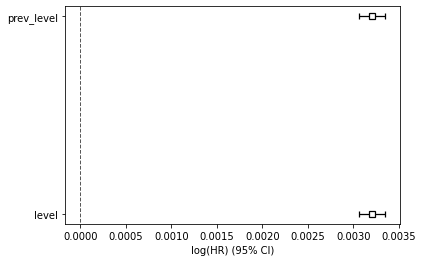

In [119]:
from lifelines import CoxTimeVaryingFitter

ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(
    df, 
    id_col="rank", 
    event_col="event", 
    start_col="start", 
    stop_col="stop", 
    show_progress=True
)
ctv.print_summary()
ctv.plot()

Text(0, 0.5, 'time in days days')

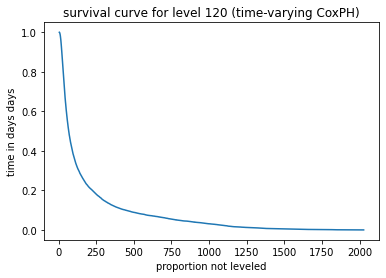

In [165]:
z = ctv._compute_baseline_survival()
z = z.reset_index()
z["index"] = z["index"]/(3600*24)
plt.plot(z["index"], z["baseline survival"])
plt.title("survival curve for level 120 (time-varying CoxPH)")
plt.xlabel("proportion not leveled")
plt.ylabel("time in days days")

In [134]:
from pathlib import Path
Path("../data/cox_tv_dev").mkdir(parents=True, exist_ok=True)

In [135]:
with open("../data/cox_tv_dev/level_120.pickle", "wb") as fp:
    pickle.dump(ctv, fp)

In [150]:
with open("../data/cox_tv_dev/level_120.pickle", "rb") as fp:
    ctv = pickle.load(fp)

In [152]:
del ctv.__dict__["event_observed"]
del ctv.__dict__["start_stop_and_events"]
del ctv.__dict__["weights"]

In [157]:
df[df["rank"] == df["rank"].max()]

,rank,level,start,stop,prev_level,event
1599734,14853,3,0,50,2,0
1599735,14853,4,50,137,3,0
1599736,14853,5,137,279,4,0
1599737,14853,6,279,677,5,0
1599738,14853,7,677,1091,6,0
...,...,...,...,...,...,...
1599847,14853,116,855475,863937,115,0
1599848,14853,117,863937,868064,116,0
1599849,14853,118,868064,874158,117,0
1599850,14853,119,874158,907300,118,0


In [159]:
ctv.predict_survival_function(df[df["rank"] == df["rank"].max()])

AttributeError: 'CoxTimeVaryingFitter' object has no attribute 'predict_survival_function'